## Scrapping from FPL API
Inspired by the best rank in 9 FPL Seasons and motivated by an almost top 100K finish, this project seeks to explore insights that would land "Nene's Ballerz" a top 90K rank next season (24/25), or Arsenal the index 0. Ultimately, through this notebook we'll parse out data from the FPL API for both players and managers data from the previous season (23/24) in a bid to highlight decisions that were enabling and the ones that show areas of improvement. 

References
- https://medium.com/analytics-vidhya/getting-started-with-fantasy-premier-league-data-56d3b9be8c32
- https://gist.githubusercontent.com/James-Leslie/82abbb4c6808321b0cf8c801a84ff22e/raw/9b5a238a52159d8e856adcc2aa18a734b9178561/FPL-endpoints.csv

In [1]:
import os
import pandas as pd
import requests
import json
from pprint import pprint

In [2]:
## base_url for all FPL API endpoints
base_url = 'https://fantasy.premierleague.com/api/'

## get data from the end-point
r = requests.get(base_url+'bootstrap-static/').json()

## inspect top level fields
pprint(r, indent=2,depth=1,compact=True)

{ 'element_stats': [...],
  'element_types': [...],
  'elements': [...],
  'events': [...],
  'game_settings': {...},
  'phases': [...],
  'teams': [...],
  'total_players': 10905021}


In [3]:
### managers by gameweek
#total_managers = r['total_players']

### gameweek events
game_weeks  = r['events']

pprint(game_weeks[0])



{'average_entry_score': 64,
 'chip_plays': [{'chip_name': 'bboost', 'num_played': 163222},
                {'chip_name': '3xc', 'num_played': 287198}],
 'cup_leagues_created': False,
 'data_checked': True,
 'deadline_time': '2023-08-11T17:30:00Z',
 'deadline_time_epoch': 1691775000,
 'deadline_time_game_offset': 0,
 'finished': True,
 'h2h_ko_matches_created': False,
 'highest_score': 127,
 'highest_scoring_entry': 3383750,
 'id': 1,
 'is_current': False,
 'is_next': False,
 'is_previous': False,
 'most_captained': 355,
 'most_selected': 355,
 'most_transferred_in': 1,
 'most_vice_captained': 19,
 'name': 'Gameweek 1',
 'ranked_count': 0,
 'release_time': None,
 'top_element': 395,
 'top_element_info': {'id': 395, 'points': 14},
 'transfers_made': 0}


In [4]:
### pull gameweek events
game_week_details = pd.json_normalize(r['events'])


In [5]:
game_week_details.columns


Index(['id', 'name', 'deadline_time', 'release_time', 'average_entry_score',
       'finished', 'data_checked', 'highest_scoring_entry',
       'deadline_time_epoch', 'deadline_time_game_offset', 'highest_score',
       'is_previous', 'is_current', 'is_next', 'cup_leagues_created',
       'h2h_ko_matches_created', 'ranked_count', 'chip_plays', 'most_selected',
       'most_transferred_in', 'top_element', 'transfers_made',
       'most_captained', 'most_vice_captained', 'top_element_info.id',
       'top_element_info.points'],
      dtype='object')

In [6]:
### confirm all gw have been checked
game_week_details['data_checked'].value_counts()

True    38
Name: data_checked, dtype: int64

In [7]:
### select key columns
columns_to_keep = ['id','name','average_entry_score','highest_score']
game_week_details = game_week_details[columns_to_keep]
game_week_details.head()

,id,name,average_entry_score,highest_score
0,1,Gameweek 1,64,127
1,2,Gameweek 2,44,120
2,3,Gameweek 3,44,128
3,4,Gameweek 4,72,148
4,5,Gameweek 5,44,102


### Individual Team Analysis

In [8]:
#### write a function that inputs team id and outputs season points per gw and rank

def get_manager_past_seasons_perf(manager_id):
    '''get manager's season performance'''
    ### run get request
    r = requests.get(
        base_url + 'entry/' + str(manager_id) + '/history/'
    ).json()
    df = pd.json_normalize(r['past'])
    
    df['manager_id'] = manager_id
    return df

In [9]:
get_manager_past_seasons_perf(5152606)[['manager_id','season_name','total_points','rank']].reset_index().sort_values(by = 'season_name', ascending = False)



,index,manager_id,season_name,total_points,rank
8,8,5152606,2023/24,2474,124788
7,7,5152606,2022/23,2498,176797
6,6,5152606,2021/22,2176,1355901
5,5,5152606,2020/21,1922,3376635
4,4,5152606,2019/20,1928,2742516
3,3,5152606,2018/19,1888,3224944
2,2,5152606,2017/18,1590,4304749
1,1,5152606,2016/17,1494,3531285
0,0,5152606,2013/14,1896,1419205


In [10]:
### write a function that inputs manager id and outputs GW points for entire season alongside chips 

def get_gw_points(manager_id):
    '''get a manager's past season history'''
    r = requests.get(
        base_url + 'entry/'+ str(manager_id)+'/history/'
    ).json()
    df = pd.json_normalize(r['current'])
    dt = pd.json_normalize(r['chips']).rename(columns={'name':'chip_used'})#,'event':'game_week'
    dft = df.merge(dt,on='event', how='left')
    dft['manager_id'] = manager_id
    dft['chip_used'].fillna('none',inplace=True)


    return dft
   

In [11]:
### print GW points for season
nenes_ballerz = get_gw_points(5152606)[['event','points','total_points','points_on_bench','chip_used','event_transfers','event_transfers_cost','rank','overall_rank','percentile_rank','bank','value']].reset_index().sort_values(by = 'event',ascending=True)
nenes_ballerz

,index,event,points,total_points,points_on_bench,chip_used,event_transfers,event_transfers_cost,rank,overall_rank,percentile_rank,bank,value
0,0,1,75,75,15,none,0,0,1648468,1648468,NaN,5,1000
1,1,2,49,124,2,none,1,0,3142665,1745184,NaN,0,1002
2,2,3,60,176,7,none,3,8,806267,1258116,NaN,4,1007
3,3,4,84,260,2,none,1,0,1439976,666287,NaN,4,1012
4,4,5,51,311,10,none,0,0,2124361,408068,NaN,4,1014
5,5,6,82,393,13,none,2,0,1650238,267711,NaN,0,1017
6,6,7,30,423,6,none,0,0,9148136,1235480,NaN,0,1019
7,7,8,56,471,2,none,4,8,1744630,1154593,NaN,4,1019
8,8,9,84,555,2,none,1,0,1712619,884922,NaN,4,1021
9,9,10,79,634,9,wildcard,0,0,1463731,546315,NaN,4,1016


### Rank by Gameweek

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [13]:
### get total managers in the season
total_managers = r['total_players']

pprint(total_managers)#.head()

10905021


In [14]:
### add total managers
nenes_ballerz['total_managers'] = total_managers 

## compute rank to total managers ratio
nenes_ballerz['rank_over_managers'] = nenes_ballerz['overall_rank']/nenes_ballerz['total_managers']

nenes_ballerz.head()

,index,event,points,total_points,points_on_bench,chip_used,event_transfers,event_transfers_cost,rank,overall_rank,percentile_rank,bank,value,total_managers,rank_over_managers
0,0,1,75,75,15,none,0,0,1648468,1648468,NaN,5,1000,10905021,0.151166
1,1,2,49,124,2,none,1,0,3142665,1745184,NaN,0,1002,10905021,0.160035
2,2,3,60,176,7,none,3,8,806267,1258116,NaN,4,1007,10905021,0.115370
3,3,4,84,260,2,none,1,0,1439976,666287,NaN,4,1012,10905021,0.061099
4,4,5,51,311,10,none,0,0,2124361,408068,NaN,4,1014,10905021,0.037420


Text(0, 0.5, 'Rank')

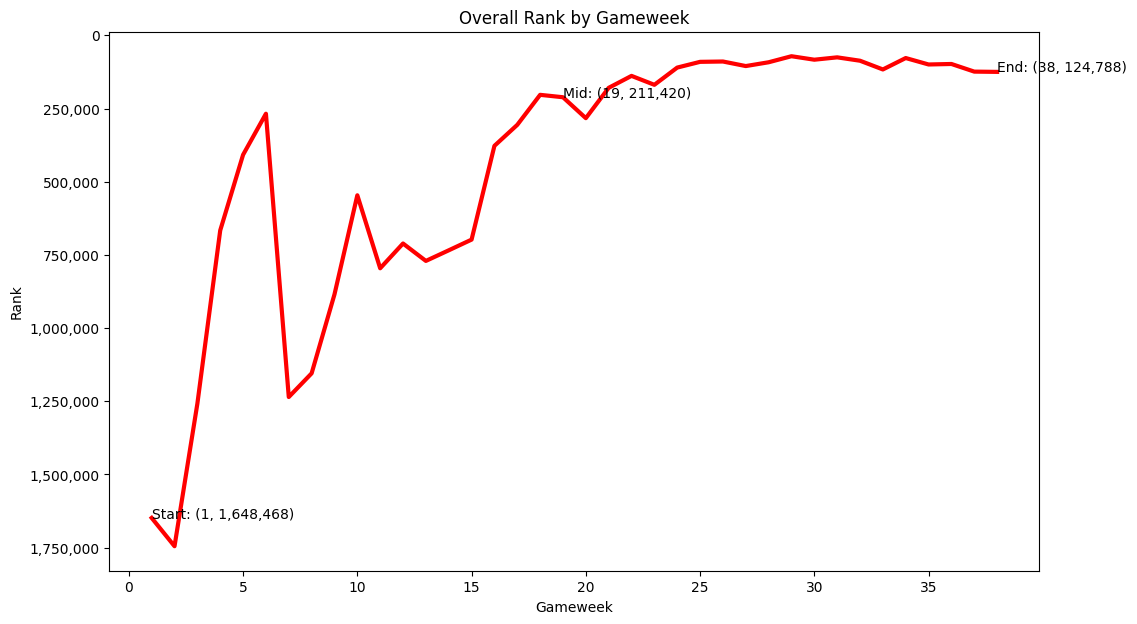

In [15]:
### plot rank by GW 
#rank_by_GW = nenes_ballerz['overall_rank'].value_counts().sort_index(by)

plt.figure(figsize=(12,7))

## invert y axis values
#nenes_ballerz['rank_over_managers_inverted'] = nenes_ballerz['rank_over_managers'].max() - nenes_ballerz['rank_over_managers']

ax = sns.lineplot(data = nenes_ballerz,x='event',y='overall_rank',color = 'red',linewidth = 3)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: '{:,.0f}'.format(x)))

## invert y axis
ax.invert_yaxis()

x = nenes_ballerz['event']
y = nenes_ballerz['overall_rank']

# Add data labels to the start, mid, and end points

plt.annotate(f'Start: ({x.iloc[0]}, {y.iloc[0]:,.0f})', xy=(x.iloc[0], y.iloc[0]), xytext=(x.iloc[0], y.iloc[0] - 50))
plt.annotate(f'Mid: ({x.iloc[len(x) // 2-1]}, {y.iloc[len(y) // 2-1]:,.0f})', xy=(x.iloc[len(x) // 2-1], y.iloc[len(y) // 2-1]), 
             xytext=(x.iloc[len(x) // 2-1], y.iloc[len(y) // 2-1] - 50)
             )
plt.annotate(f'End: ({x.iloc[-1]}, {y.iloc[-1]:,.0f})', xy=(x.iloc[-1], y.iloc[-1]), xytext=(x.iloc[-1], y.iloc[-1] - 50)
             )


ax.set_title('Overall Rank by Gameweek')
ax.set_xlabel('Gameweek')
ax.set_ylabel('Rank')


### Points by GameWeek Average

In [16]:
### merge gameweek details to managers' team gw performance
nenes_ballerz = pd.merge(left =nenes_ballerz ,right=game_week_details,left_on='event',right_on='id',how='left').rename(columns={'average_entry_score':'average_score'})
nenes_ballerz['diff_from_avg'] = nenes_ballerz['points'] - nenes_ballerz['average_score'] 
#nenes_ballerz.head()

,index,event,points,total_points,points_on_bench,chip_used,event_transfers,event_transfers_cost,rank,overall_rank,percentile_rank,bank,value,total_managers,rank_over_managers,id,name,average_score,highest_score,diff_from_avg
0,0,1,75,75,15,none,0,0,1648468,1648468,NaN,5,1000,10905021,0.151166,1,Gameweek 1,64,127,11
1,1,2,49,124,2,none,1,0,3142665,1745184,NaN,0,1002,10905021,0.160035,2,Gameweek 2,44,120,5
2,2,3,60,176,7,none,3,8,806267,1258116,NaN,4,1007,10905021,0.115370,3,Gameweek 3,44,128,16
3,3,4,84,260,2,none,1,0,1439976,666287,NaN,4,1012,10905021,0.061099,4,Gameweek 4,72,148,12
4,4,5,51,311,10,none,0,0,2124361,408068,NaN,4,1014,10905021,0.037420,5,Gameweek 5,44,102,7


In [17]:
### difference from average stats
nenes_ballerz['diff_from_avg'].describe()

count    38.000000
mean     13.552632
std      11.497820
min     -19.000000
25%       7.500000
50%      13.500000
75%      19.500000
max      46.000000
Name: diff_from_avg, dtype: float64

In [31]:
### pull points for min and max difference gameweeks
### pull points for worst gameweek vs average score

max_negative_dev = nenes_ballerz['diff_from_avg'].min()
points_for_gw = nenes_ballerz.loc[nenes_ballerz['diff_from_avg'] == max_negative_dev, ['points', 'average_score','name']]

points_for_gw


,points,average_score,name
6,30,49,Gameweek 7


In [32]:
### pull points for best gameweek vs average score
max_positive_dev = nenes_ballerz['diff_from_avg'].max()
points_for_gw = nenes_ballerz.loc[nenes_ballerz['diff_from_avg']==max_positive_dev,['points', 'average_score','name']]

points_for_gw

,points,average_score,name
33,122,76,Gameweek 34


In [33]:
nenes_ballerz['chip_used'].value_counts()

none        33
wildcard     2
3xc          1
freehit      1
bboost       1
Name: chip_used, dtype: int64

Text(0, 0.5, 'Points')

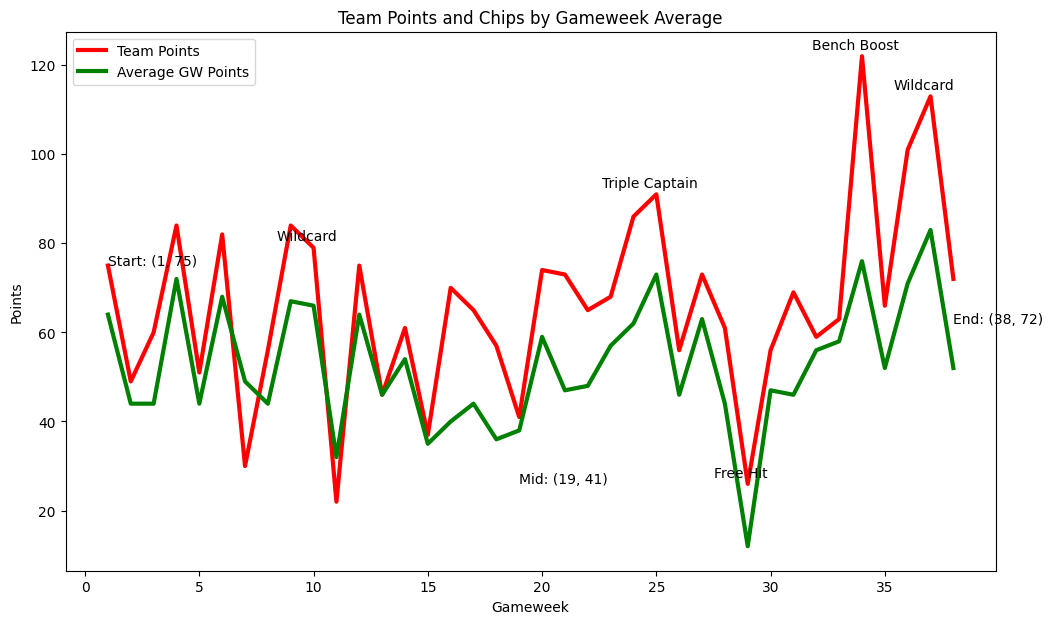

In [34]:
### Plot team points by gameweek average
plt.figure(figsize=(12,7))

ax = sns.lineplot(data=nenes_ballerz,x='event' ,y='points',color = 'red',linewidth= 3,label = 'Team Points')
ax = sns.lineplot(data=nenes_ballerz,x='event',y='average_score',color = 'green',linewidth = 3,label = 'Average GW Points')
\
# Add data labels to the start, mid, and end points
x = nenes_ballerz['event']
y = nenes_ballerz['points']

plt.annotate(f'Start: ({x.iloc[0]}, {y.iloc[0]:,.0f})', xy=(x.iloc[0], y.iloc[0]), xytext=(x.iloc[0], y.iloc[0] + 0))
plt.annotate(f'Mid: ({x.iloc[len(x) // 2-1]}, {y.iloc[len(y) // 2-1]:,.0f})', xy=(x.iloc[len(x) // 2-1], y.iloc[len(y) // 2-1]), 
             xytext=(x.iloc[len(x) // 2-1], y.iloc[len(y) // 2-1] - 15)
             )
plt.annotate(f'End: ({x.iloc[-1]}, {y.iloc[-1]:,.0f})', xy=(x.iloc[-1], y.iloc[-1]), xytext=(x.iloc[-1], y.iloc[-1] - 10)
             )

### annotate chip usage
chip_events = {'Wildcard':'wildcard','Triple Captain':'3xc','Free Hit':'freehit', 'Bench Boost':'bboost'}
for chip_name, chip_event in chip_events.items():
    chip_event_data = nenes_ballerz[nenes_ballerz['chip_used']== chip_event]
    for i, row in chip_event_data.iterrows():
        ax.annotate(chip_name,(row['event'],row['points']),textcoords="offset points", xytext=(-5,5),ha= 'center')


plt.legend()
ax.set_title('Team Points and Chips by Gameweek Average')
ax.set_xlabel('Gameweek')
ax.set_ylabel('Points')


### Breakout Chips Usage

In [29]:

### analyze chips and influence on points relative to average points
chips_usage = nenes_ballerz[nenes_ballerz['chip_used']!='none']
cols = ['name','points','average_score','diff_from_avg','chip_used']
chips_usage = chips_usage[cols]
chips_usage

,name,points,average_score,diff_from_avg,chip_used
9,Gameweek 10,79,66,13,wildcard
24,Gameweek 25,91,73,18,3xc
28,Gameweek 29,26,12,14,freehit
33,Gameweek 34,122,76,46,bboost
36,Gameweek 37,113,83,30,wildcard


In [30]:
# pull stats on chips usage
chips_usage.describe()

,points,average_score,diff_from_avg
count,5.000000,5.000000,5.000000
mean,86.200000,62.000000,24.200000
std,37.745198,28.609439,13.935566
min,26.000000,12.000000,13.000000
25%,79.000000,66.000000,14.000000
50%,91.000000,73.000000,18.000000
75%,113.000000,76.000000,30.000000
max,122.000000,83.000000,46.000000


In [35]:
### break out points on bench
nenes_ballerz['points_on_bench'].describe()

count    38.000000
mean      8.447368
std       6.599334
min       0.000000
25%       3.250000
50%       7.500000
75%      11.750000
max      31.000000
Name: points_on_bench, dtype: float64

In [38]:
### pull out the gameweeks with min and max points on bench
### max points on bench
max_points_on_bench = nenes_ballerz['points_on_bench'].max()  
points_on_bench_gw = nenes_ballerz.loc[nenes_ballerz['points_on_bench']==max_points_on_bench,['points','average_score','points_on_bench','name']]

points_on_bench_gw

,points,average_score,points_on_bench,name
22,68,57,31,Gameweek 23


In [39]:
### min points on bench
min_points_on_bench = nenes_ballerz['points_on_bench'].min()
points_on_bench_gw = nenes_ballerz.loc[nenes_ballerz['points_on_bench']==min_points_on_bench,['points','average_score','points_on_bench','name']]
points_on_bench_gw

,points,average_score,points_on_bench,name
16,65,44,0,Gameweek 17
33,122,76,0,Gameweek 34
34,66,52,0,Gameweek 35


### Transfers Breakdown

In [47]:
### transfers analysis
transfer_deets = ['name','points','diff_from_avg','bank','event_transfers','event_transfers_cost']


transfers_made = nenes_ballerz[transfer_deets]
transfers_made = transfers_made.loc[transfers_made['bank']>0]
transfers_made.reset_index().sort_values(by='diff_from_avg',ascending=True).head(10)


,index,name,points,diff_from_avg,bank,event_transfers,event_transfers_cost
7,10,Gameweek 11,22,-10,4,0,0
9,12,Gameweek 13,46,0,7,1,0
11,14,Gameweek 15,37,2,7,1,0
15,18,Gameweek 19,41,3,41,0,0
28,31,Gameweek 32,59,3,15,0,0
29,32,Gameweek 33,63,5,34,2,0
3,4,Gameweek 5,51,7,4,0,0
10,13,Gameweek 14,61,7,11,2,0
26,29,Gameweek 30,56,9,12,1,0
22,25,Gameweek 26,56,10,18,1,0


- To a great extent, Nene's Balerz mapped a slightly better than average, with Gameweek 34 the best performing with a gain of 46 points from the average. Gameweek 7 was the worst performed with a deviance of -19 points.
- The chips usage was beneficial in gunning points from the average, generating an average of 24 positive points.
- On average Nene's Ballerz left 8 points on the bench, at game week 23 leaving 31 possible points due to a wrong team selection.  